# STA3301 - Semester 2, 2019 - Assignent 1

### Enrique Bustamante
### u1034971

In [1]:
import pandas as pd
import numpy as np
import altair as alt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from math import log
from itertools import combinations
import copy

## Question 1

In [2]:
semic = pd.read_csv('Data/semic.dat', sep='\s+')
semic.columns=['ers', 'brs', 'ebrs', 'hfe']
semic.head()

,ers,brs,ebrs,hfe
0,14.62,226.0,7.000,128.40
1,15.63,220.0,3.375,52.62
2,14.62,217.4,6.375,113.90
3,15.00,220.0,6.000,98.01
4,14.50,226.5,7.625,139.90


#### a)

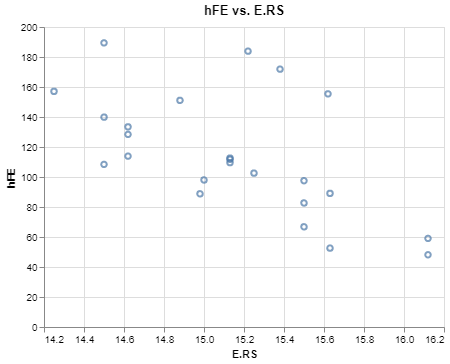

In [3]:
alt.Chart(semic, title='hFE vs. E.RS')\
        .mark_point()\
        .encode(
            x=alt.X('ers', title='E.RS', scale=alt.Scale(zero=False)), 
            y=alt.Y('hfe', title='hFE'))

E.RS seems to have a mild negative correlation to hFE.

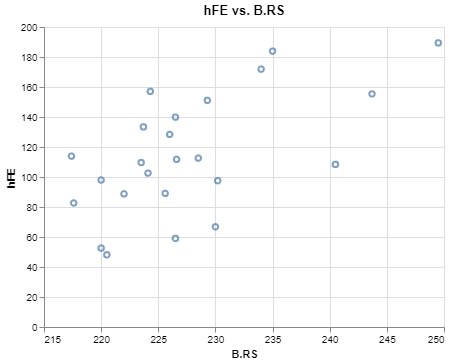

In [4]:
alt.Chart(semic, title='hFE vs. B.RS')\
        .mark_point()\
        .encode(
            x=alt.X('brs', title='B.RS', scale=alt.Scale(zero=False)), 
            y=alt.Y('hfe', title='hFE'))

B.RS might have a mild positive correlation to hFE, but the amount of clustering towards the lower values indicates there may not be much correlation at all.

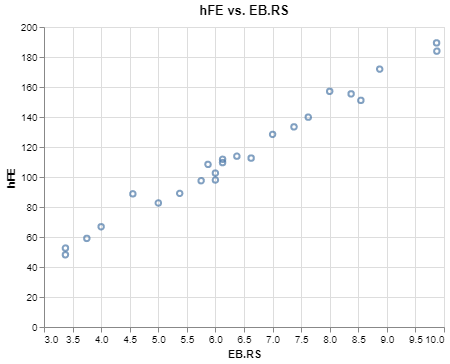

In [5]:
alt.Chart(semic, title='hFE vs. EB.RS')\
        .mark_point()\
        .encode(
            x=alt.X('ebrs', title='EB.RS', scale=alt.Scale(zero=False)), 
            y=alt.Y('hfe', title='hFE'))

EB.RS has an apparently high correlation to hFE, as demonstrated by the clear (approximate) line generated by the datapoints.

#### b)

In [6]:
semicFit = smf.ols('hfe ~ ebrs + brs + ers', semic).fit()
print(semicFit.summary())
print(f'Coefficients: \n{semicFit.params}')

                            OLS Regression Results                            
Dep. Variable:                    hfe   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     530.2
Date:                Tue, 03 Sep 2019   Prob (F-statistic):           3.21e-19
Time:                        20:33:30   Log-Likelihood:                -69.287
No. Observations:                  24   AIC:                             146.6
Df Residuals:                      20   BIC:                             151.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.0097     44.187      0.362      0.7

$\hat{hFE}  = 16.0097 + 19.4235x_1  + 0.2349x_2  - 5.2407x_3$

#### c)

In [7]:
print(f'variance: {semicFit.scale}')

variance: 22.609981340360555


#### d)

In [8]:
print(sm.stats.anova_lm(semicFit))

            df        sum_sq       mean_sq            F        PR(>F)
ebrs       1.0  35840.470457  35840.470457  1585.161435  1.598031e-20
brs        1.0     19.231423     19.231423     0.850572  3.673831e-01
ers        1.0    105.899826    105.899826     4.683764  4.272500e-02
Residual  20.0    452.199627     22.609981          NaN           NaN


EB.RS is highly correlated and significant to the output of hFE with E.RS also being statistically significant at a 0.05 level, although just barely.

B.RS is not significant at the 0.05 level (if the data is fit again without B.RS, the adjusted R-Squared goes up slightly).


#### e)

In [9]:
p = semicFit.get_prediction({'ebrs':6.125, 'brs':223.5, 'ers':15.13})
p.predicted_mean[0]

108.19315918035907

$\hat{hFE} = 108.1932$

#### f)

In [10]:
pPredInt = p.conf_int(obs=True, alpha=.01)
print(f'99% prediction interval: {pPredInt[0,0]} - {pPredInt[0,1]}')

99% prediction interval: 94.29423184698531 - 122.09208651373284


#### g)

In [11]:
pConfInt = p.conf_int( alpha=0.01)
print(f'99% confidence interval: {pConfInt[0,0]} - {pConfInt[0,1]}')

99% confidence interval: 105.0102799400672 - 111.37603842065094


The confidence interval is the range where a determined percentage of the values would fall for a random variable (in this case 99%). In other words, 99% of the time, E[y|x] will be within the range provided by this confidence interval. In the case of the prediction interval, it also factors in the errors from the prediction and thus is a wider range as it estimates y, not E[y|x].

#### h)

In [12]:
semicCntr = semic/semic.mean()
X = np.array(semicCntr[['ers', 'brs', 'ebrs']])
S = np.matmul(X.transpose(), X)
r = np.zeros([3,3])
for i in range(3):
    for j in range(3):
        r[i,j] = S[i,j]/(np.sqrt(S[i,i]*S[j,j]))
print(r)

[[1.         0.99868743 0.95480478]
 [0.99868743 1.         0.96558185]
 [0.95480478 0.96558185 1.        ]]


There would seem to be a strong, positive correlation between all three regressors, particularly between B.RS and E.RS. It would seem that any change to any one of them will have a significant impact on the rest.

#### i)

In [13]:
#code for partial_corr from https://gist.github.com/fabianp/9396204419c7b638d38f

from scipy import stats, linalg

def partial_corr(C):
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)

            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr

    return P_corr

In [14]:
partial_corr(semic)

array([[ 1.        ,  0.98713369,  0.38150306, -0.50162891],
       [ 0.98713369,  1.        , -0.26121051,  0.39902939],
       [ 0.38150306, -0.26121051,  1.        ,  0.98346083],
       [-0.50162891,  0.39902939,  0.98346083,  1.        ]])

We are interested in the last row (or column) of the above array as it is the one that represents hFE. overall, there is a very strong correlation with EB.RS which matches the output of the plot being almost a straight line. This variable has a very strong effect on the hFE.

There isn't much of a correlation between hFE and B.Rs but a mild negative correlation between E.RS and hFE. Both of these also align with the output from the plots. E.RS will tend to reduce the amount of hFE mildly while B.RS will have a very small positive effect.

#### j)

The regressors most likely to be important in predicting a response will be EB.RS and E.RS. the effect of B.RS is likely to be minimal.

#### k)

In [15]:
coef = ['Intercept', 'EB.RS', 'B.RS', 'E.RS']
for i in range(4):
    r = [0, 0, 0, 0]
    r[i] = 1
    t = semicFit.t_test(r)
    print(f'{coef[i]}')
    print(f'{t}')
    print(f'{coef[i]} {"not " \
                        if t.pvalue >= 0.05 \
                        else ""} significant at alpha=0.05 level')
    print('--------------------------'*3 + '\n'*2)

Intercept
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            16.0097     44.187      0.362      0.721     -76.163     108.182
Intercept not  significant at alpha=0.05 level
------------------------------------------------------------------------------


EB.RS
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            19.4235      0.802     24.213      0.000      17.750      21.097
EB.RS  significant at alpha=0.05 level
------------------------------------------------------------------------------


B.RS
                             Test for Constraints                             
                 coe

#### l)

Based on the data above, the best fitted model may likely be:

$\hat{hFE} = \beta_0 + \beta_1EB.RS$

While the intercept does not test as significant, it is still necessary to include. The other two variables, E.RS, B.RS, do not have much of a correlation to the dependent variable and also fail in the ANOVA table.

## Question 2

In [16]:
cars = pd.read_csv('Data/car.dat', sep='\s+')
cars.head()

,Country,AO,POP,DEN,GDP,PR,CON,TR
0,Austria,0.27,7.5,89,7.7,49,1.11,2.6
1,Belgium,0.30,9.8,323,9.8,59,1.04,1.6
2,Canada,0.42,23.5,2,8.7,17,2.82,0.1
3,Denmark,0.28,5.1,119,11.0,56,1.21,1.9
4,Finland,0.24,4.8,16,7.1,49,1.22,2.2


#### a)

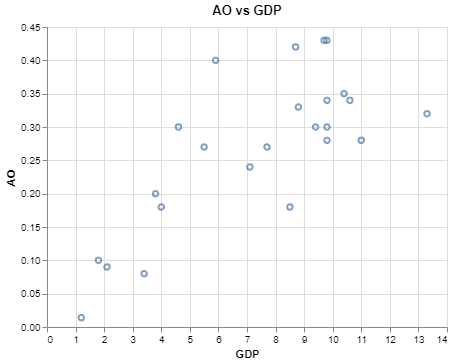

In [17]:
alt.Chart(cars, title='AO vs GDP')\
    .mark_point()\
    .encode(x='GDP', y=alt.Y('AO', scale=alt.Scale(zero=False)))

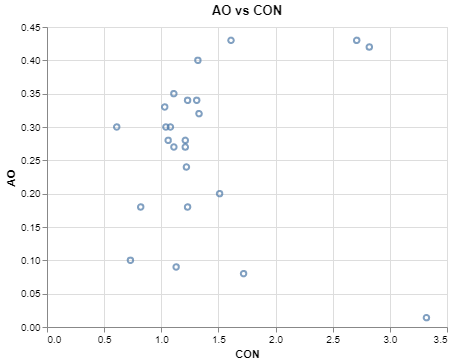

In [18]:
alt.Chart(cars, title='AO vs CON')\
    .mark_point()\
    .encode(x='CON', y=alt.Y('AO', scale=alt.Scale(zero=False)))

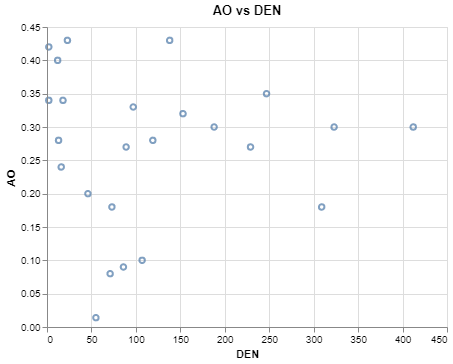

In [19]:
alt.Chart(cars, title='AO vs DEN')\
    .mark_point()\
    .encode(x='DEN', y=alt.Y('AO', scale=alt.Scale(zero=False)))

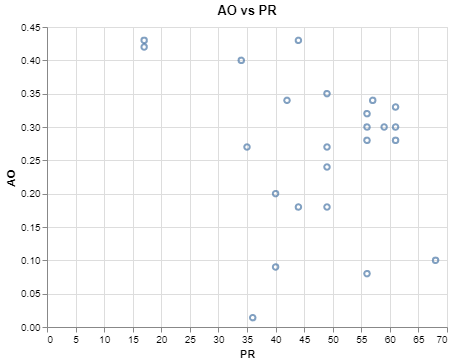

In [20]:
alt.Chart(cars, title='AO vs PR')\
.mark_point().encode(x='PR', y=alt.Y('AO', scale=alt.Scale(zero=False)))

Car ownership and GDP seem to be the more strongly correlated of the four relationships chosen. It would appear to have a relatively strong positive correlation. Car ownership and amount of public transport taken appear to have a negative correlation, whereas consumption of petrol and population density do not seem to have much correlation, if any, with car ownership.

#### b)

In [21]:
#code for forward_selected from 
# https://planspace.org/20150423-forward_selection_with_statsmodels/
def forward_selected(data, response):
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [22]:
m = forward_selected(cars[['AO', 'POP', 'DEN', 'GDP', 'PR', 'CON', 'TR']], 'AO')
print(m.summary())
print(f'Variance: {m.scale}')

                            OLS Regression Results                            
Dep. Variable:                     AO   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     25.26
Date:                Tue, 03 Sep 2019   Prob (F-statistic):           2.23e-07
Time:                        20:33:32   Log-Likelihood:                 40.624
No. Observations:                  24   AIC:                            -71.25
Df Residuals:                      19   BIC:                            -65.36
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4831      0.087      5.541      0.0

$\hat{AO} = 0.4831 + 0.307GDP - 0.0623TR - 0.01001CON - 0.0045PR$

My output only has the final result of the forward selection process, but the full ode can be observed above.

The Forward selection is an iterative procedure, starting with only the intercept and testing the addition each parameter, individually, to the model and keeping the new model with the greatest improvement to a selected statistit (F, AIC, Adjusted R-Squared, etc...). The process keeps going, adding one parameter at a time until there is no improvement gained.

#### c)

In [23]:
#code is variation on forward_selected

def backward_selected(data, response):
    cols = set(data.columns)
    cols.remove(response)
    cols = list(cols)
    currentScore, bestNewScore = 0.0, 0.0
    loop = True
    
    while loop and currentScore == bestNewScore:
        scoresAndCandidates = []
        rCols = copy.deepcopy(cols)
        for col in rCols:
            rCols.remove(col)
            formula = "{} ~ {}".format(response, ' + '.join(rCols))
            score = smf.ols(formula, data).fit().rsquared_adj
            scoresAndCandidates.append((score, col))
        scoresAndCandidates.sort()
        bestNewScore, bestCandidate = scoresAndCandidates.pop()
        if currentScore < bestNewScore:
            cols.remove(bestCandidate)
            currentScore = bestNewScore
        else:
            loop = False
    formula = f"{response} ~ {' + '.join(cols)}"
    model = smf.ols(formula, data).fit()
    return model

In [24]:
m = backward_selected(cars[['AO', 'POP', 'DEN', 'GDP', 'PR', 'CON', 'TR']], 'AO')
print(m.summary())
print(f'Variance: {m.scale}')

                            OLS Regression Results                            
Dep. Variable:                     AO   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     15.88
Date:                Tue, 03 Sep 2019   Prob (F-statistic):           4.01e-06
Time:                        20:33:32   Log-Likelihood:                 41.155
No. Observations:                  24   AIC:                            -68.31
Df Residuals:                      17   BIC:                            -60.06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4706      0.092      5.143      0.0

$\hat{AO} = 0.1824 + 0.0291GDP - 0.0344TR - 3.067e-05POP - 0.0017PR - 1.16e05DEN$

Backwards elimination process:

Based on a chosen metric (F score, AIC, Adj. R-Squared, etc…), iteratively test improvements on that metric from a fit model that uses all possible inputs. The improvements are measured by removing one input at a time and selecting the best new model, as per the chosen metric, with now one less parameter. This is repeated, removing one parameter from the model, until no improvements are gained from removing a parameter.


#### d)

In [25]:
#calculate press statistic
def calcPress(X, Y, Ypred):
    X = np.matrix(X)
    h = np.matmul(X,
                  np.matmul(np.linalg.inv(np.matmul(X.transpose(), X)), 
                            X.transpose()))
    press = 0
    #for i in range(lenth(Y)):
    press = press + (((Y - Ypred)**2 / (1-np.diagonal(h)))**2).sum()
    return press

In [26]:
def calcYpred(model, inputs):
    y = model.predict(inputs)
    return y

In [27]:
variables = ['GDP', 'PR', 'CON', 'TR']
#variables = variables.drop('y')
bestFormula = ''
bestAIC = 9999999
maxAIC = 0

fullModelMSE = smf.ols('AO ~ POP + DEN + GDP + PR + CON + TR', cars).fit().mse_resid

for i in range(1, len(variables)+1):
    combs = combinations(variables, i)
    
    
    for c in combs:
        formula = 'AO ~'
        for v in c:
            formula = formula + f' + {v}'
        formula = formula.replace('~ + ', '~ ')
        fit = smf.ols(formula, cars).fit()
        fit.predict()
        if fit.aic < bestAIC:
            bestAIC = fit.aic
            bestFormula = formula
        if fit.aic > maxAIC:
            maxAIC = fit.aic
        ypred = calcYpred(fit, cars[[x for x in c]])
        print(f'{formula} : ')
        press = str(calcPress(cars[[x for x in c]], cars.AO, ypred))[:6]
        cm = ((fit.mse_resid * fit.df_resid) / fullModelMSE)\
                - len(cars) + 2*len(fit.params)
        
        print(f'AIC: {str(fit.aic)[:8]} - PRESS: {press} - RSquared: {str(fit.rsquared)[:6]} - m: {len(fit.params)} - Cm: {str(cm)[:6]}')

AO ~ GDP : 
AIC: -52.8908 - PRESS: 0.0019 - RSquared: 0.5633 - m: 2 - Cm: 29.026
AO ~ PR : 
AIC: -34.7088 - PRESS: 0.0105 - RSquared: 0.0685 - m: 2 - Cm: 84.578
AO ~ CON : 
AIC: -33.0052 - PRESS: 0.0127 - RSquared: 6.7618 - m: 2 - Cm: 92.271
AO ~ TR : 
AIC: -33.1466 - PRESS: 0.0105 - RSquared: 0.0058 - m: 2 - Cm: 91.612
AO ~ GDP + PR : 
AIC: -57.2986 - PRESS: 0.0015 - RSquared: 0.6656 - m: 3 - Cm: 19.538
AO ~ GDP + CON : 
AIC: -51.1158 - PRESS: 0.0026 - RSquared: 0.5674 - m: 3 - Cm: 30.568
AO ~ GDP + TR : 
AIC: -58.3450 - PRESS: 0.0012 - RSquared: 0.6799 - m: 3 - Cm: 17.936
AO ~ PR + CON : 
AIC: -34.5919 - PRESS: 0.0079 - RSquared: 0.1388 - m: 3 - Cm: 78.686
AO ~ PR + TR : 
AIC: -32.7925 - PRESS: 0.0115 - RSquared: 0.0717 - m: 3 - Cm: 86.214
AO ~ CON + TR : 
AIC: -31.2181 - PRESS: 0.0158 - RSquared: 0.0088 - m: 3 - Cm: 93.280
AO ~ GDP + PR + CON : 
AIC: -59.6559 - PRESS: 0.0009 - RSquared: 0.7211 - m: 4 - Cm: 15.305
AO ~ GDP + PR + TR : 
AIC: -58.7871 - PRESS: 0.0015 - RSquared: 0.7108

In [28]:
print(smf.ols(bestFormula, cars).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                     AO   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     25.26
Date:                Tue, 03 Sep 2019   Prob (F-statistic):           2.23e-07
Time:                        20:33:33   Log-Likelihood:                 40.624
No. Observations:                  24   AIC:                            -71.25
Df Residuals:                      19   BIC:                            -65.36
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4831      0.087      5.541      0.0

Selected Model: $\hat{AO} = 0.4831 + 0.307GDP - 0.0623TR - 0.1001CON - 0.0045PR$

## Question 3

In [29]:
jelly = pd.read_csv('Data/jelly.dat', sep='\s+')
jelly['Site Name'] = jelly.Site.map(lambda x: 'Salamander Bay' 
                                                if x==2 
                                                else 'Dangar Island')
jelly.head()

,Breadth,Length,Site,Site Name
0,6.5,8.5,1,Dangar Island
1,6.0,9.0,1,Dangar Island
2,6.5,9.0,1,Dangar Island
3,7.0,9.0,1,Dangar Island
4,8.0,9.5,1,Dangar Island


#### a)

In [30]:
j1Fit = smf.ols('Breadth ~ Length', jelly[jelly.Site==1]).fit()
print(j1Fit.summary())

                            OLS Regression Results                            
Dep. Variable:                Breadth   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     214.6
Date:                Tue, 03 Sep 2019   Prob (F-statistic):           3.72e-12
Time:                        20:33:33   Log-Likelihood:                -29.794
No. Observations:                  22   AIC:                             63.59
Df Residuals:                      20   BIC:                             65.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9374      0.920     -3.194      0.0

Site 1:  $\hat{Breadth} = -29374 + 1.0534Length$

In [31]:
j2Fit = smf.ols('Breadth ~ Length', jelly[jelly.Site==2]).fit()
print(j2Fit.summary())

                            OLS Regression Results                            
Dep. Variable:                Breadth   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     36.68
Date:                Tue, 03 Sep 2019   Prob (F-statistic):           4.28e-06
Time:                        20:33:34   Log-Likelihood:                -40.551
No. Observations:                  24   AIC:                             85.10
Df Residuals:                      22   BIC:                             87.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8003      2.826     -0.283      0.7

Site 2:  $\hat{Breadth} = -0.8003 + 0.8924Length$

#### b)

Yes, they are.  The slope for Site 1 (Dangar Island) is 1.0534, while Site 2 (Salamander Bay) is 0.8924.

#### c)

Yes, they are. The intercepts for the two sites are -2.0374 for Dangar Island and -0.8003 for Salamander Bay.

#### d)

d)	Yes, the jellies in Salamander Bay do not seem to grow as much in Breadth per unit length compared to those in Dangar Island. Also, given the differences in intercepts, it seems likely that Dangar Island has the smaller Jellies and an overall larger range of jelly sizes.

#### e)

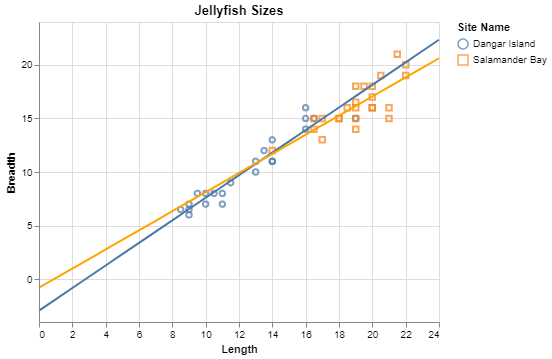

In [32]:
alt.Chart(jelly, title='Jellyfish Sizes')\
    .mark_point()\
    .encode(
        x='Length', 
        y='Breadth', 
        color='Site Name:N', 
        shape='Site Name:N') + \

alt.Chart(pd.DataFrame({'Breadth':[j1Fit.params[0] + x*j1Fit.params[1] 
                                   for x in range(25)], 
                        'Length':[x for x in range(25)]}))\
    .mark_line()\
    .encode(x='Length', y='Breadth') + \
alt.Chart(pd.DataFrame({'Breadth':[j2Fit.params[0] + x*j2Fit.params[1] 
                                   for x in range(25)], 
                        'Length':[x for x in range(25)]}))\
    .mark_line(color='orange')\
    .encode(x='Length', y='Breadth')

The jellies that have been measured in Dangar island are generally smaller than those of Salamander Bay.  The sizes of Salamander Bay Jellies do seem to cluster closer together than those of Dangar Island, where there is a more linear relationship between length and breadth.

## Question 4

#### a)

In [33]:
cloud = pd.read_csv('Data\cloud.dat', sep='\s+')
#cloud.A = cloud.A + 1
for col in ['S', 'C', 'P', 'E']:
    cloud[f'A{col}'] = cloud.A * cloud[col]
cloud.head()

,A,T,S,C,P,E,y,AS,AC,AP,AE
0,0,0,1.75,13.4,0.274,2,2.61,0.00,0.0,0.000,0
1,1,3,4.10,3.9,0.198,2,1.81,4.10,3.9,0.198,2
2,0,4,2.35,5.3,0.526,1,1.78,0.00,0.0,0.000,0
3,1,6,4.25,7.1,0.250,1,0.83,4.25,7.1,0.250,1
4,0,9,1.60,6.9,0.018,2,1.28,0.00,0.0,0.000,0


In [34]:
cFit = smf.ols('y ~ A + T + S + C + P + E + AS + AC + AP + AE', cloud).fit()
print(cFit.summary())
print(f'Variance: {cFit.scale}')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     6.518
Date:                Tue, 03 Sep 2019   Prob (F-statistic):            0.00473
Time:                        20:33:34   Log-Likelihood:               -0.43477
No. Observations:                  20   AIC:                             22.87
Df Residuals:                       9   BIC:                             33.82
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3469      0.971     -0.357      0.7

$\hat{y} = +3.4404A -0.014T +0.1267S +0.0745C +1.1913P +0.6372E -0.851AS -0.058AC +0.5972AP +0.0675AE$

#### b)

In [35]:
cloud['normResiduals'] = cFit.get_influence().resid_studentized_internal
cols = ['A', 'T', 'S', 'C', 'P', 'E', 'AS', 'AC', 'AP', 'AE']
cloud['yFit'] = cFit.predict(cloud[cols])
cloud['residuals'] = cloud.y - cloud.yFit

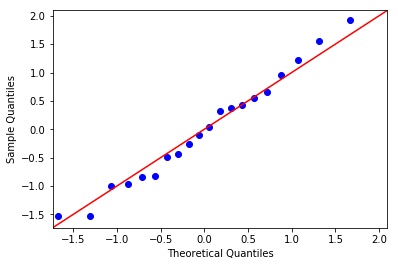

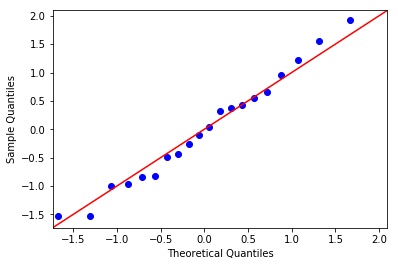

In [36]:
sm.qqplot(cFit.get_influence().resid_studentized_internal, line='45')

The plot is relatively straight, indicating that it is likely that the errors are normally distributed.

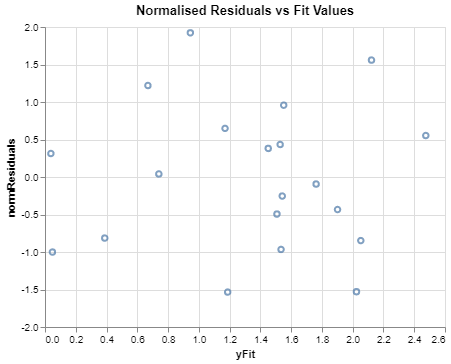

In [37]:
alt.Chart(cloud, title='Normalised Residuals vs Fit Values')\
    .mark_point()\
    .encode(x='yFit', y='normResiduals')

Due to the low number of data points it is difficult to discern any particular kind of shape. It appears to be a rough horizontal band with a few extraneous points at around yFit approximately 0.95, 1.2 and 2

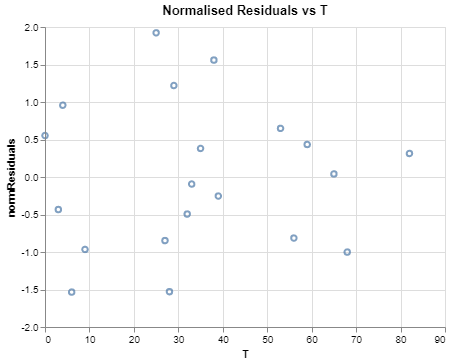

In [38]:
alt.Chart(cloud, title='Normalised Residuals vs T')\
    .mark_point()\
    .encode(x='T', y='normResiduals')

No pattern.

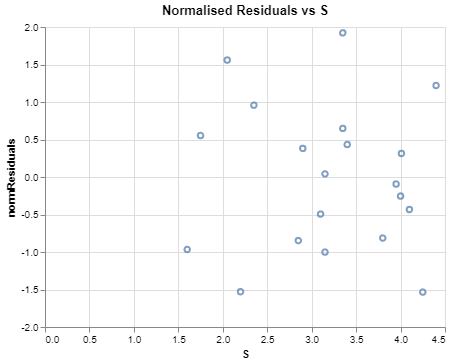

In [39]:
alt.Chart(cloud, title='Normalised Residuals vs S')\
    .mark_point()\
    .encode(x='S', y='normResiduals')

No pattern

Based on the above, there are 3 potentially suspect days that could be checked, they are output below:

In [40]:
cloud[cloud.yFit.between(0.8, 0.95) | 
      cloud.yFit.between(1.18 , 1.2) | 
      cloud.yFit.between(1.9, 2)]

,A,T,S,C,P,E,y,AS,AC,AP,AE,normResiduals,yFit,residuals
1,1,3,4.10,3.9,0.198,2,1.81,4.10,3.9,0.198,2,-0.433748,1.901518,-0.091518
3,1,6,4.25,7.1,0.250,1,0.83,4.25,7.1,0.250,1,-1.534145,1.187471,-0.357471
5,0,25,3.35,4.9,0.194,1,1.51,0.00,0.0,0.000,0,1.922019,0.944784,0.565216


#### c)

In [41]:
infVals = cFit.get_influence()\
                .summary_frame()[['hat_diag', 'dffits', 'cooks_d']]
infVals['Observation'] = [x for x in range(1,21)]

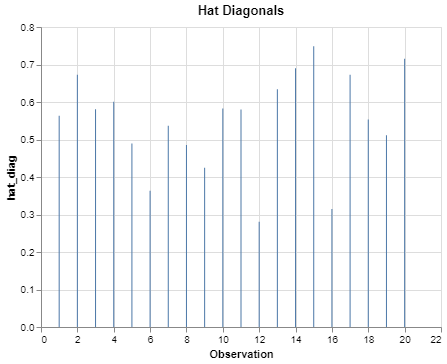

In [42]:
alt.Chart(infVals, title='Hat Diagonals')\
    .mark_bar(size = 1)\
    .encode(x='Observation', y='hat_diag')

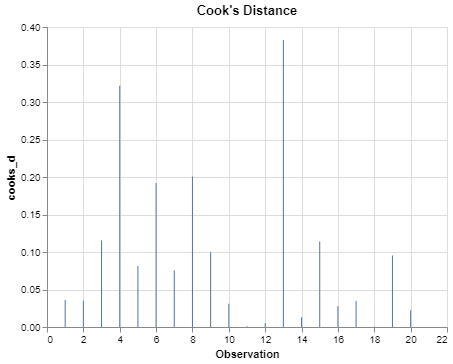

In [43]:
alt.Chart(infVals, title='Cook\'s Distance')\
    .mark_bar(size = 1)\
    .encode(x='Observation', y='cooks_d')

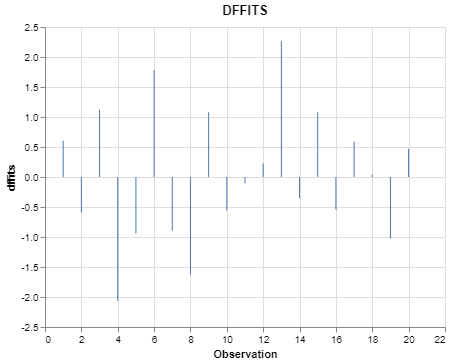

In [44]:
alt.Chart(infVals, title='DFFITS')\
    .mark_bar(size = 1)\
    .encode(x='Observation', y='dffits')

From the above, it would seem that observations 4, 6, 8 and 13 are influential, according to the measures of Cook's Distance and DFFITS.

#### d)

In [45]:
c = cloud[['A', 'T', 'S', 'C', 'P', 'E', 'AS', 'AC', 'AP', 'AE']]
cloudCentre = c/c.mean()
X = np.array(cloudCentre)
S = np.matmul(X.transpose(), X)
r = np.zeros([len(c.columns), len(c.columns)])
for i in range(len(c.columns)):
    for j in range(len(c.columns)):
        r[i,j] = S[i,j]/(np.sqrt(S[i,i]*S[j,j]))
print('Correlation Matrix:')
print(r)

Correlation Matrix:
[[1.         0.64256489 0.72120346 0.53029855 0.34166074 0.64142698
  0.9734384  0.93730365 0.93738963 0.9486833 ]
 [0.64256489 1.         0.84799712 0.66728898 0.56851086 0.74250474
  0.61291929 0.64058842 0.5147156  0.59153462]
 [0.72120346 0.84799712 1.         0.83358679 0.78549816 0.89494229
  0.74088248 0.68138565 0.71313477 0.69758125]
 [0.53029855 0.66728898 0.83358679 1.         0.81627961 0.86482022
  0.52033589 0.56577028 0.49723139 0.50472945]
 [0.34166074 0.56851086 0.78549816 0.81627961 1.         0.69197526
  0.3508304  0.32032685 0.36448103 0.3279379 ]
 [0.64142698 0.74250474 0.89494229 0.86482022 0.69197526 1.
  0.63660705 0.6031766  0.60833479 0.6761234 ]
 [0.9734384  0.61291929 0.74088248 0.52033589 0.3508304  0.63660705
  1.         0.91969464 0.96254776 0.94155453]
 [0.93730365 0.64058842 0.68138565 0.56577028 0.32032685 0.6031766
  0.91969464 1.         0.87885739 0.89211022]
 [0.93738963 0.5147156  0.71313477 0.49723139 0.36448103 0.60833479
 

There are large correlations between various parameters, particularly A and the ones created from A (AS, AC, AP, AE). There's a strong correlation as well (above 0.8) between T and S, S and C, S and P, S and E, C and P, C and E, and some others.

In [46]:
#print('Diagonals of inverse of correlation matrix:')
# for i in range(3):
#     print(f'{np.linalg.inv(r)[i,i]}')
#try:
invCorr = np.linalg.inv(r)
print('Diagonals of inverse of correlation matrix:')
for i in range(len(invCorr)):
    print(invCorr[i,i])
#except:
    #print('The correlation matrix is singular and has no inverse.')

Diagonals of inverse of correlation matrix:
34.312010956441455
9.0806370108121
33.85502877231934
11.105083158282548
7.09482539266636
13.497634517098044
43.498196075202024
13.33345420944505
22.921560267400583
17.267988492816983


Various elements of the diagonal of the inverse correlation matrix are above 5, one as high as 43.497 indicating strong multicollinearity.

In [47]:
cFit.condition_number

1698.8089256108183

The condition number is quite large, 1698.8089, indicating that there is a serious collinearity problem.

At this stage it is probably necessary to change the variables being used in the model (probably removing the newly created composites) and creating new variables with C and it's collinears.